Set up environment so it does not crash with cpu error.

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=8abba11af7100e22e12e2a8267aa4c8079cb30618a3677e78b60280088251212
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 86.6 GB  | Proc size: 1.4 GB
GPU RAM Free: 39822MB | Used: 691MB | Util   2% | Total 40960MB


Install and import libraries

In [4]:
!pip install transformers
!pip install datasets
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.2 MB/s eta 0:00:

In [5]:
import tensorflow as tf
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer, DistilBertForTokenClassification, TrainingArguments, Trainer
from datasets import load_dataset
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

In [6]:
## Load Dataset

dataset = load_dataset("conll2003")
train_dataset = dataset["train"]
test_dataset = dataset["test"]


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
from transformers import AutoTokenizer, DistilBertForTokenClassification, TrainingArguments, Trainer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = DistilBertForTokenClassification.from_pretrained(model_name, num_labels=len(dataset["train"].features["pos_tags"].feature.names))


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN t

In [8]:
selected_pos_tags = ['CC', 'CD', 'DT', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']

# Map the original POS tags to the new subset
pos_tag_map = {tag: idx for idx, tag in enumerate(selected_pos_tags)}

def map_and_filter(example):
    new_tags = []
    new_tokens = []
    for token, tag in zip(example['tokens'], example['pos_tags']):
        if tag in selected_pos_tags:
            new_tokens.append(token)
            new_tags.append(pos_tag_map[tag])
    if len(new_tags) > 0:
        example['tokens'] = new_tokens
        example['pos_tags'] = new_tags
        return example
    else:
        return None

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_filter, remove_columns=['chunk_tags', 'ner_tags'])
    dataset[split] = dataset[split].filter(lambda x: x is not None)


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [9]:
def tokenize_and_align_labels(batch):
    tokenized_input = tokenizer(batch["tokens"], is_split_into_words=True, padding="max_length", truncation=True, max_length=128)
    labels = []
    for i, label in enumerate(batch["pos_tags"]):
        word_ids = tokenized_input.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
                previous_word_idx = word_idx
            else:
                label_ids.append(-100)
        labels.append(label_ids)
    tokenized_input["labels"] = labels
    return tokenized_input

train_dataset = dataset['train'].map(tokenize_and_align_labels, batched=True)
test_dataset = dataset['test'].map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [10]:
# Training arguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=400,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
)

In [11]:
from sklearn.metrics import classification_report, accuracy_score

def compute_metrics(p):
    predictions, labels = p.predictions, p.label_ids
    predictions = predictions.argmax(axis=-1)
    
    # Flatten the labels and predictions, ignoring padding tokens (-100)
    flat_true_labels = labels[labels != -100].flatten()
    flat_pred_labels = predictions[labels != -100].flatten()
    
    # Compute the classification report
    report = classification_report(
        flat_true_labels,
        flat_pred_labels,
        target_names=selected_pos_tags,
        labels=list(range(len(selected_pos_tags))),
        output_dict=True,
        zero_division=0
    )
    
    # Compute the accuracy
    acc = accuracy_score(flat_true_labels, flat_pred_labels)
    
    # Extract the required metrics
    metrics = {
        "accuracy": acc,
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1 score": report["weighted avg"]["f1-score"]
    }
    return metrics


In [12]:
import time 
start_time = time.time()

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score
1,0.219500,0.257537,0.935315,0.934908,0.940007,0.937112
2,0.137200,0.229020,0.941411,0.942302,0.945604,0.943741
3,0.088800,0.235777,0.942940,0.943891,0.946773,0.945200


TrainOutput(global_step=2634, training_loss=0.3386108967827049, metrics={'train_runtime': 161.528, 'train_samples_per_second': 260.778, 'train_steps_per_second': 16.307, 'total_flos': 1376994620968704.0, 'train_loss': 0.3386108967827049, 'epoch': 3.0})

In [14]:
#get training time
end_time = time.time()
distilbert_training_time = end_time - start_time
print("DistilBERT training time:", distilbert_training_time)

DistilBERT training time: 162.23162007331848


In [15]:
POS_BERT = torch.save(model.state_dict(), "pos_distilbert.pt")

In [16]:
#get number of trained parameters
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in DistilBERT model:", num_parameters)

Number of trainable parameters in DistilBERT model: 66399023


In [23]:
# Evaluate the model
eval_result = trainer.evaluate()

# Print the evaluation metrics
print(f"Accuracy: {eval_result['eval_accuracy']:.2f}")
print(f"Precision: {eval_result['eval_precision']:.2f}")
print(f"Recall: {eval_result['eval_recall']:.2f}")
print(f"F1-score: {eval_result['eval_f1']:.2f}")



Accuracy: 0.94
Precision: 0.94
Recall: 0.95


KeyError: ignored

In [18]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

def custom_collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # Pad both input_ids and attention_mask together
    padded_batch = tokenizer.pad({"input_ids": input_ids, "attention_mask": attention_mask}, return_tensors='pt')
    
    input_ids = padded_batch['input_ids']
    attention_mask = padded_batch['attention_mask']

    # Pad labels
    max_length = max([len(lbl) for lbl in labels])
    padded_labels = []
    for lbl in labels:
        lbl_len = len(lbl)
        padded_lbl = lbl + [-100] * (max_length - lbl_len)
        padded_labels.append(padded_lbl)
    labels = torch.tensor(padded_labels)

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

test_dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=custom_collate_fn)
device = model.device

true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        labels = batch.pop("labels")
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predicted = torch.argmax(logits, dim=-1)
        true_labels.extend(labels.cpu().numpy().tolist())
        predicted_labels.extend(predicted.cpu().numpy().tolist())

# Remove padding and special tokens labels
true_labels_no_pad = []
predicted_labels_no_pad = []
for true_label_seq, predicted_label_seq in zip(true_labels, predicted_labels):
    for true_label, predicted_label in zip(true_label_seq, predicted_label_seq):
        if true_label != -100:  # Ignore padding and special tokens labels
            true_labels_no_pad.append(true_label)
            predicted_labels_no_pad.append(predicted_label)

true_labels = np.array(true_labels_no_pad)
predicted_labels = np.array(predicted_labels_no_pad)


Evaluating: 100%|██████████| 216/216 [00:04<00:00, 53.01it/s]


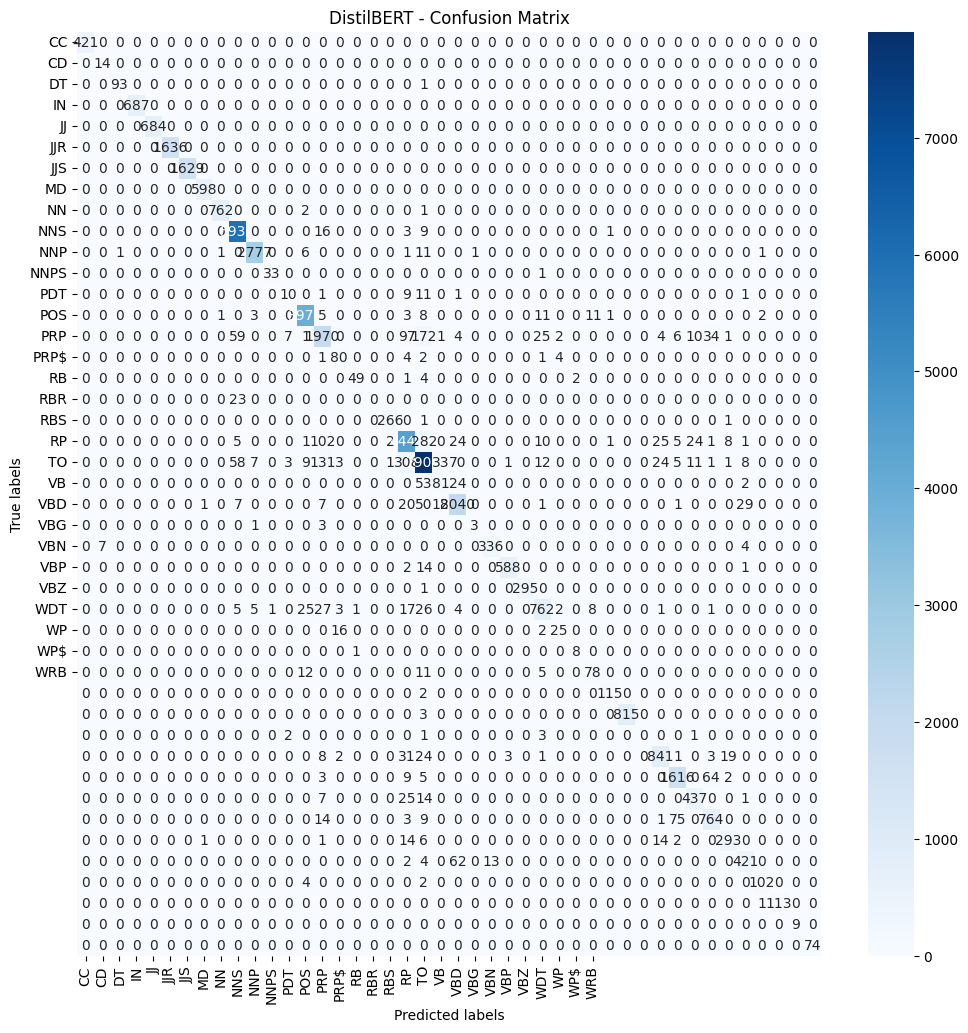

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get label names from the dataset
label_names = selected_pos_tags

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('DistilBERT - Confusion Matrix')
plt.savefig("pos_CM.png")
plt.show()


XAI


In [25]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=af8637cd8958fbc6f44184afc1f6a5472e7e9c5e59e4449e9d304f46af4241df
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [26]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:32'

In [27]:
!pip install git+https://github.com/rentruewang/koila.git@v0.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rentruewang/koila.git (to revision v0.1.1) to /tmp/pip-req-build-7ec6y6ls
  Running command git clone --filter=blob:none --quiet https://github.com/rentruewang/koila.git /tmp/pip-req-build-7ec6y6ls
  Running command git checkout -q 42a7cc0dedb1e10b5a62260e369ab2e68c1cab4d
  Resolved https://github.com/rentruewang/koila.git to commit 42a7cc0dedb1e10b5a62260e369ab2e68c1cab4d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.4 MB/s eta 0:00:00
  Created wheel for koila: filename=koila-0.1.1-py3-none-any.whl size=18987 sha256=f27896a3ef23e2b7803ee66a28f319aca83f84a702ff156a1cbc274a45ca9b66
  Stored in directory: /tmp/pip-ephem-wheel-cache-rz3ucd83/wheels/f2/c8/a3/38ae15fe2cdce2032646750dd7db44b174a4d8da728223ef67
Successfully built koila


In [28]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 82.9 GB  | Proc size: 4.4 GB
GPU RAM Free: 36806MB | Used: 3707MB | Util   9% | Total 40960MB


In [29]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "1"


In [30]:
token_data = [example['tokens'] for example in test_dataset]

sentence_data = [' '.join(tokens) for tokens in token_data]

In [31]:
#create explanations for the entire sentence and then analyze the weights assigned to each token in the sentence

from transformers import AutoTokenizer
from lime.lime_text import LimeTextExplainer
import torch
import numpy as np

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def predict_function(sentences):
    encodings = tokenizer(sentences, truncation=True, padding=True, return_tensors='pt')
    with torch.no_grad():
        output = model(encodings['input_ids'].to(model.device), encodings['attention_mask'].to(model.device))
    predicted_probabilities = torch.softmax(output.logits, dim=2).cpu().detach().numpy()
    max_probs = np.max(predicted_probabilities, axis=2)  # Take the maximum probability for each token
    return max_probs


# Create a LIME explainer
explainer = LimeTextExplainer(class_names=label_names,verbose=True)

sentence_to_explain = sentence_data[15]
explanation = explainer.explain_instance(sentence_to_explain, predict_function)

print(f"Explanation for sentence: {explanation.as_list()}")


Intercept 0.7099308711828516
Prediction_local [0.37161699]
Right: 0.35038236
Explanation for sentence: [('Bitar', -0.23716738184129968), ('off', -0.06388932438616987), ('pulled', -0.051710193538588085), ('did', 0.025810375258880615), ('saves', 0.015603041392236772), ('they', -0.013164685258793848), ('fine', -0.011549901048921788), ('whenever', -0.0022458163149326263)]


In [32]:
explanation.show_in_notebook()

In [33]:
from transformers import AutoTokenizer
from lime.lime_text import LimeTextExplainer
import torch
import numpy as np

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def predict_function(sentences):
    encodings = tokenizer(sentences, truncation=True, padding=True, return_tensors='pt')
    with torch.no_grad():
        output = model(encodings['input_ids'].to(model.device), encodings['attention_mask'].to(model.device))
    predicted_probabilities = torch.softmax(output.logits, dim=2).cpu().detach().numpy()
    max_probs = np.max(predicted_probabilities, axis=2)  # Take the maximum probability for each token
    return max_probs

def custom_tokenizer(text):
    tokens = tokenizer.tokenize(text)
    return tokens

# Create a LIME explainer
explainer = LimeTextExplainer(class_names=label_names, verbose=True, split_expression=custom_tokenizer)

# Take a subset of sentences, e.g., the first 20 sentences
sentences_explain = sentence_data[:4]

# Loop through the sentences and create explanations for each token
for i, sentence in enumerate(sentences_explain):
    # Tokenize the sentence
    tokens = custom_tokenizer(sentence)
    # Loop through the tokens and create explanations for each token
    for j, token in enumerate(tokens):
        # Create a modified sentence that contains only the current token
        modified_sentence = " ".join([t if idx != j else token for idx, t in enumerate(tokens)])
        # Create the explanation for the modified sentence
        explanation = explainer.explain_instance(modified_sentence, predict_function)
        # Print the explanation and the current sentence and token indexes
        print(f"Explanation for sentence {i + 1}, token {j + 1}/{len(tokens)}: {explanation.as_list()}")
        print(f"Sentence: {sentence}")
        print(f"Token: {token}")
        print("\n")


Intercept 0.9461747543617218
Prediction_local [0.99325495]
Right: 0.9815066
Explanation for sentence 1, token 1/12: [('japan', 0.02164611961953057), ('-', 0.021515035790885262), ('win', -0.010035021039163022), ('get', 0.007818455369328006), ('soccer', 0.004547150349936575), ('china', 0.0022842934358051894), ('surprise', 0.0010025719011266113), ('in', -0.0008438431817223449), (',', -0.0005041683754391331), ('.', -0.00035039785521144773)]
Sentence: SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .
Token: soccer


Intercept 0.9483472824116604
Prediction_local [0.99299799]
Right: 0.9815066
Explanation for sentence 1, token 2/12: [('japan', 0.020451898137705978), ('-', 0.01730832970175678), ('win', -0.007314102382715991), ('get', 0.00628960052058355), ('soccer', 0.002718448911790501), ('in', 0.0019022514241177721), ('defeat', 0.0012357745049382262), ('.', 0.0009368128617590454), ('china', 0.0005925481579401887), ('surprise', 0.0005291474634440066)]
Sentence: SOCCER - JAPAN GET LUCKY

In [39]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer
import torch
import numpy as np

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_names)).to("cuda")

def predict_function(sentences):
    encodings = tokenizer(sentences, truncation=True, padding=True, return_tensors='pt')
    with torch.no_grad():
        output = model(encodings['input_ids'].to(model.device), encodings['attention_mask'].to(model.device))
    predicted_probabilities = torch.softmax(output.logits, dim=1).cpu().detach().numpy()
    return predicted_probabilities

# Create a LIME explainer
explainer = LimeTextExplainer(class_names=label_names, verbose=True)

# Take a subset of sentences, e.g., the first 4 sentences
sentences_explain = sentence_data[:4]

# Loop through the sentences and create explanations for each sentence
for i, sentence in enumerate(sentences_explain):
    # Create the explanation for the sentence
    explanation = explainer.explain_instance(sentence, predict_function, num_features=len(label_names))
    
    # Get the LIME predicted label index and associated probability
    probabilities = np.array([prob for _, prob in explanation.as_list()])
    lime_label_index = np.argmax(probabilities)
    lime_label = label_names[lime_label_index]
    lime_probability = probabilities[lime_label_index]

    # Print the LIME predicted label and associated probability
    print(f"Sentence {i + 1}: {sentence}")
    print(f"LIME predicted label: {lime_label}, Probability: {lime_probability:.4f}\n")


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Intercept 0.03654841592892903
Prediction_local [0.03195093]
Right: 0.03242068
Sentence 1: SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .
LIME predicted label: NN, Probability: -0.0001

Intercept 0.03569858203935519
Prediction_local [0.03511314]
Right: 0.0349771
Sentence 2: Nadim Ladki
LIME predicted label: CD, Probability: 0.0002

Intercept 0.03540207496174309
Prediction_local [0.03402207]
Right: 0.034497313
Sentence 3: AL-AIN , United Arab Emirates 1996-12-06
LIME predicted label: JJS, Probability: 0.0001

Intercept 0.03425185437421937
Prediction_local [0.03320002]
Right: 0.033187363
Sentence 4: Japan began the defence of their Asian Cup title with a lucky 2-1 win against Syria in a Group C championship match on Friday .
LIME predicted label: CC, Probability: 0.0005



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Initialize the lists to store the F1 scores
f1_scores_lime = []
f1_scores_transformer = []

# Loop through the range of sample sizes
for size in range(100, 6810, 100):
    # Calculate the F1 scores for both models
    f1_score_lime = f1_score(true_labels[:size], lime_labels[:size], average='weighted')
    f1_score_transformer = f1_score(true_labels[:size], y_pred_transformer[:size], average='weighted')

    # Append the F1 scores to the respective lists
    f1_scores_lime.append(f1_score_lime)
    f1_scores_transformer.append(f1_score_transformer)

# Plot the F1 scores for both models
plt.figure()
plt.plot(range(100, 6810, 100), f1_scores_lime, label='LIME F1 Score', marker='o')
plt.plot(range(100, 6810, 100), f1_scores_transformer, label='Transformer F1 Score', marker='o')
plt.xlabel('Complexity')
plt.ylabel('Fidelity')
plt.title('DistilBERT')
plt.legend()
plt.savefig('F1_scores_Transformer.png')
plt.show()


In [ ]:
!pip install shap

In [ ]:
import shap
import torch
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Define a function to tokenize the input text and get the model's output
def predict_for_shap(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs.to(model.device))
    return outputs.logits.cpu().numpy()

# Use SHAP to explain the predictions
explainer = shap.Explainer(predict_for_shap, tokenizer)
shap_values = explainer(sentence_data[:5])

# Visualize the explanations for the first sentence
shap.plots.text(shap_values[0])
